# Revisiting problematic lines

Some of the line maps have discontinuities between the ABCD fields. In this notebook, we are going to work out what is wrong and fix it.

## [O I] 6300 line 

This has a sky component, which is probably causing the problem. However, we ought to be able to remove it since the LMC is redshifted by over 200 km/s.

Also, we can use the ratio of 6363/6300 in the faint parts to guide us. 

In [48]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cmasher as cm
from mpdaf.obj import Cube
import regions
import sys
import warnings
sys.path.append("../lib")
import moments
import extract

import astropy.units as u
import astropy.constants as const

sns.set_context("talk")
sns.set_color_codes()

Start off by using the subcubes, as we did in the 05-04 notebook

In [21]:
labels = "ABCD"
csub = {
    label: 
    Cube(f"../big-data/lmc-30dor-{label}-subcube-62-71-contsub.fits") 
    for label in labels
}
corig = {
    label: 
    Cube(f"../big-data/lmc-30dor-{label}-subcube-62-71.fits") 
    for label in labels
}

In [25]:
C_KMS = const.c.to(u.km/u.s).value

def wavlimits(wav0, vlim=[100.0, 300.0]):
    wav1 = wav0 * (1.0 + vlim[0] / C_KMS)
    wav2 = wav0 * (1.0 + vlim[1] / C_KMS)
    return wav1, wav2
      

In [27]:
oi_window_median = {label: cube.select_lambda(6250, 6400).median(axis=(1, 2)) for label, cube in csub.items()}

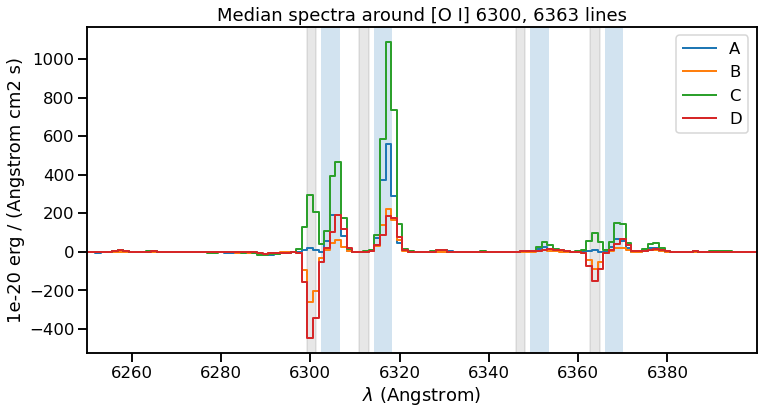

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
for label, spec in oi_window_median.items():
    spec.plot(label=label, linewidth=2)

#wav1, wav2 = wavlimits(6300.30)
for wav0 in 6300.30, 6363.78, 6312.06, 6347.11:
    ax.axvspan(*wavlimits(wav0), alpha=0.2)
    ax.axvspan(*wavlimits(wav0, vlim=[-50, 50]), alpha=0.1, color="k")
ax.legend()
ax.set_title("Median spectra around [O I] 6300, 6363 lines")
...;

So, a few things:

1. This is the median of the BG-subtracted cube of each of the ABCD fields. I originally tried with the mean, but that was weird for the BG-subtracted ones (presumably there are a few pixels that are problematic, mainly where there is a bright star). 
2. It looks like in fields B and D the sky has been oversubtracted, whereas in A and C it has been undersubtracted. 
3. I am showing the window for velocity ranges of [-50, 50] (gray) and [100, 300] (blue) for the O I, S III and Si II lines. 
4. The latter is the default window that I have been using for line extraction, and it looks like it is missing a lot of the flux on the red side of the line profile.



So the first solution to try is just to use a better extraction window. Maybe [150, 400]

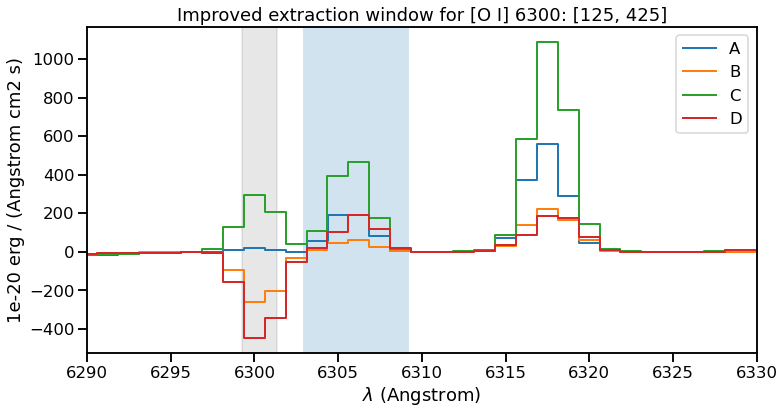

In [38]:
fig, ax = plt.subplots(figsize=(12, 6))
for label, spec in oi_window_median.items():
    spec.plot(label=label, linewidth=2)

newvlim = [125, 425]
for wav0 in 6300.30,:
    ax.axvspan(*wavlimits(wav0, vlim=newvlim), alpha=0.2)
    ax.axvspan(*wavlimits(wav0, vlim=[-50, 50]), alpha=0.1, color="k")
ax.legend()
ax.set_title(f"Improved extraction window for [O I] 6300: {newvlim}")
ax.set(
    xlim=[6290, 6330],
)
...;

In [39]:
oimoms = {
    label:
    moments.find_moments(cube.select_lambda(*wavlimits(wav0, vlim=newvlim)))
    for label, cube in csub.items()
}

../lib/moments.py:41: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)
../lib/moments.py:41: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)
../lib/moments.py:41: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)
../lib/moments.py:41: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


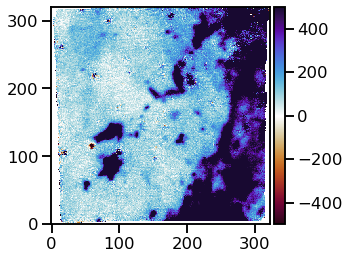

In [50]:
scale = 500
oimoms["B"][0].plot(vmin=-scale, vmax=scale, cmap=cm.fusion, colorbar="v")

Yay, all positive now!

### Fluorescent O I lines

The 8446 line had a similar problem but to a much smaller degree.